<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Ftwomoons/notebooks/smoothNF_VS_affineNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit coupling layers


In [ ]:
!pip install --quiet --upgrade dm-haiku optax 
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

In [2]:
import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [3]:
%pylab inline
import jax
import jax.numpy as jnp
import haiku as hk
import optax
from tqdm import tqdm
from functools import partial
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [4]:
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP
from sbids.tasks.two_moons import get_two_moons

### Affine coupling layer VS smooth coupling layer (trained with score matching)

In [5]:
d=2
batch_size = 256
it = 2000

In [6]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma = 0.01, normalized=True)
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)
  return batch, score

In [7]:
import arviz as az
az.style.use("arviz-darkgrid")

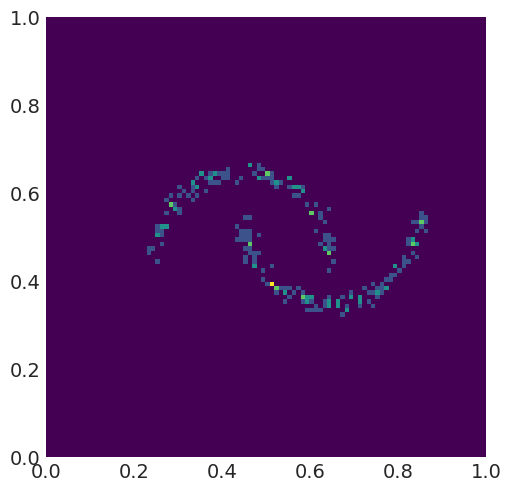

In [8]:
batch, score = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]); gca().set_aspect('equal');

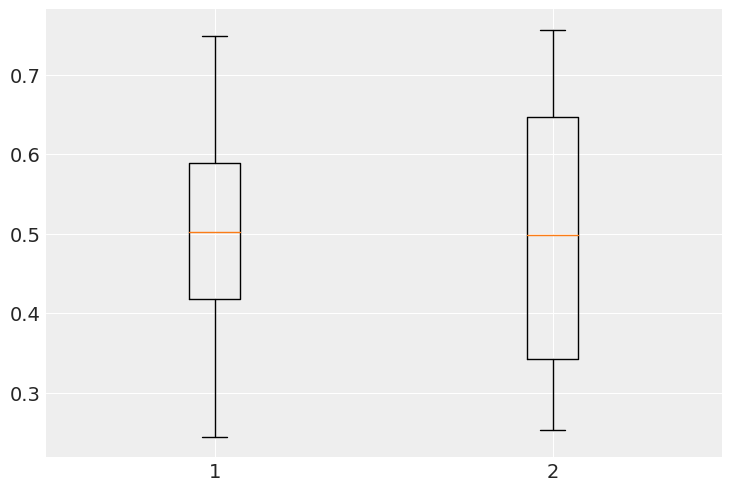

In [9]:
transformation_params = tfb.Chain([tfb.Scale([0.8,1.5]),tfb.Shift([0.07,-0.16])])
normalized = transformation_params.forward(batch)
plt.boxplot([normalized[:,0], normalized[:,1]]);

In [10]:
class AffineCoupling(hk.Module):
  
  def __init__(self,y,*args, layers=[128, 128], activation=jax.nn.leaky_relu, **kwargs):
    """ 
    Args: 
    layers, list of hidden layers
    activation, activation function for hidden layers
    """
    self.y = y
    self.layers = layers
    self.activation = activation
    super(AffineCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):
    
    net = jnp.concatenate([x, self.y], axis=-1)
    for i, layer_size in enumerate(self.layers):
      net = self.activation(hk.Linear(layer_size, name='layer%d' % i)(net))
    
    shifter = tfb.Shift(hk.Linear(output_units)(net))
    scaler = tfb.Scale(jnp.clip(jnp.exp(hk.Linear(output_units)(net)), 1e-2, 1e2))
    return tfb.Chain([shifter, scaler])    

In [49]:
bijector_affine = partial(AffineCoupling,layers = [256,256,256])
bijector_smooth = partial(AffineSigmoidCoupling, 
                   layers = [256,256,256],
                   n_components = 16, 
                   activation = jnp.sin)

NF_affine = partial(ConditionalRealNVP, n_layers = 4, bijector_fn = bijector_affine)
NF_smooth = partial(ConditionalRealNVP, n_layers = 4, bijector_fn = bijector_smooth)

model_affine = hk.without_apply_rng(hk.transform(
    lambda p:tfd.TransformedDistribution(NF_affine(2)(jnp.ones([1,1])), 
                                           tfb.Invert(transformation_params)).log_prob(p)))
model_smooth = hk.without_apply_rng(hk.transform(
    lambda p:tfd.TransformedDistribution(NF_smooth(2)(jnp.ones([1,1])), 
                                           tfb.Invert(transformation_params)).log_prob(p)))

In [12]:
rng_seq = hk.PRNGSequence(12)
params_affine = model_affine.init(next(rng_seq), p=jnp.zeros([1,2]))

rng_seq = hk.PRNGSequence(12)
params_smooth = model_smooth.init(next(rng_seq), p=jnp.zeros([1,2]))

In [13]:
def loss_affine(params, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x, param: model_affine.apply(param, x.reshape([1,2])).squeeze()), [0, None])(batch, params) 
  return  jnp.mean( jnp.sum((out - score)**2, axis=1))/1000  


def loss_smooth(params, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x, param: model_smooth.apply(param, x.reshape([1,2])).squeeze()), [0, None])(batch, params) 
  return  jnp.mean( jnp.sum((out - score)**2, axis=1))/1000  

In [14]:
learning_rate=0.0001

optimizer_affine = optax.adam(learning_rate)
opt_state_affine = optimizer_affine.init(params_affine)


optimizer_smooth = optax.adam(learning_rate)
opt_state_smooth = optimizer_smooth.init(params_smooth)

In [15]:
@jax.jit
def update_affine(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_affine)(params, batch, score)
    updates, new_opt_state = optimizer_affine.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state


@jax.jit
def update_smooth(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_smooth)(params, batch, score)
    updates, new_opt_state = optimizer_smooth.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [16]:
losses = []
master_seed = hk.PRNGSequence(0)

In [67]:
for step in tqdm(range(it)):
    batch, score = get_batch(next(master_seed))
    l, params_affine, opt_state_affine = update_affine(params_affine, opt_state_affine, batch, score)
    losses.append(l)
    if jnp.isnan(l):
      break

100%|██████████| 2000/2000 [00:08<00:00, 244.72it/s]


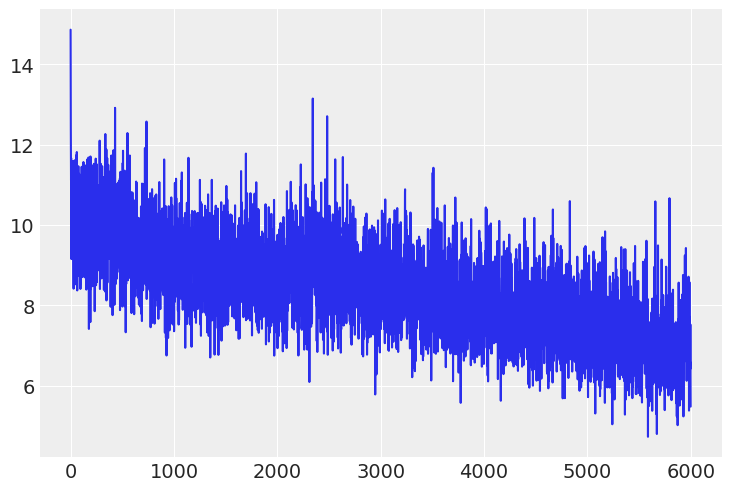

In [68]:
plt.plot(losses)

In [69]:
losses[-1]

DeviceArray(5.47993, dtype=float32)

Text(0.5, 1.0, 'NF with affine coupling layers trained with score')

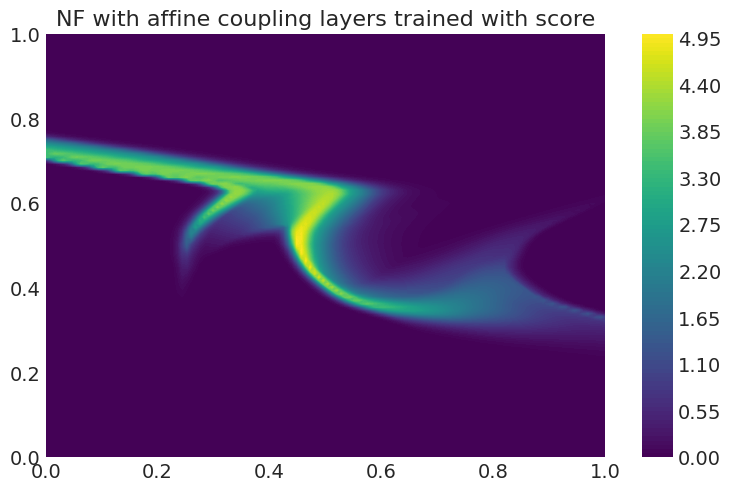

In [70]:
# predicted two moons distribution
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

im0 = jax.vmap((lambda x: model_affine.apply(params_affine, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im0), 100); colorbar()
plt.title('NF with affine coupling layers trained with score')

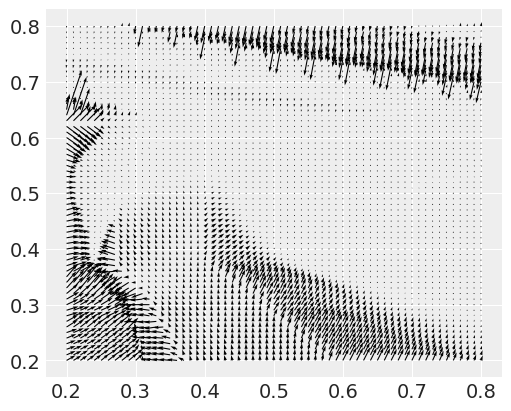

In [71]:
# score field
plt.figure(figsize=(5,4))
X = np.arange(0.2, 0.8, 0.01)
Y = np.arange(0.2, 0.8, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
pred_score = jax.vmap(jax.grad(lambda x: model_affine.apply(params_affine, x.reshape([1,2])).squeeze()))(points).reshape([len(Y), len(X),2])
quiver(X, Y, pred_score[:,:,0] ,pred_score[:,:,1]);

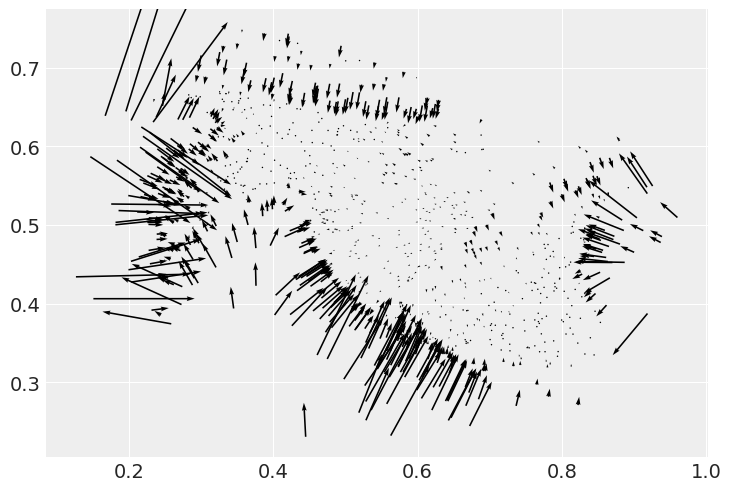

In [72]:
# score only on the two moons distribution
two_moons = get_two_moons(sigma = 0.05, normalized=True)
batch=two_moons.sample(1000, seed=next(master_seed))
pred_score = jax.vmap(jax.grad(lambda x: model_affine.apply(params_affine, x.reshape([1,2])).squeeze()))(batch)
quiver(batch.T[0], batch.T[1], pred_score[:,0] ,pred_score[:,1]);

In [23]:
losses_smooth = []
master_seed = hk.PRNGSequence(0)

In [61]:
for step in tqdm(range(it)):
    batch, score = get_batch(next(master_seed))
    l, params_smooth, opt_state_smooth = update_smooth(params_smooth, opt_state_smooth, batch, score)
    losses_smooth.append(l)

100%|██████████| 2000/2000 [00:32<00:00, 60.93it/s]


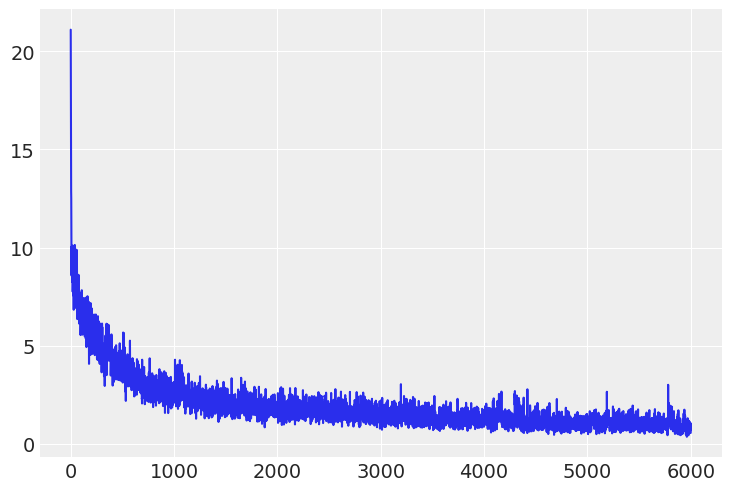

In [62]:
plot(losses_smooth)

In [63]:
losses_smooth[-1]

DeviceArray(0.5443207, dtype=float32)

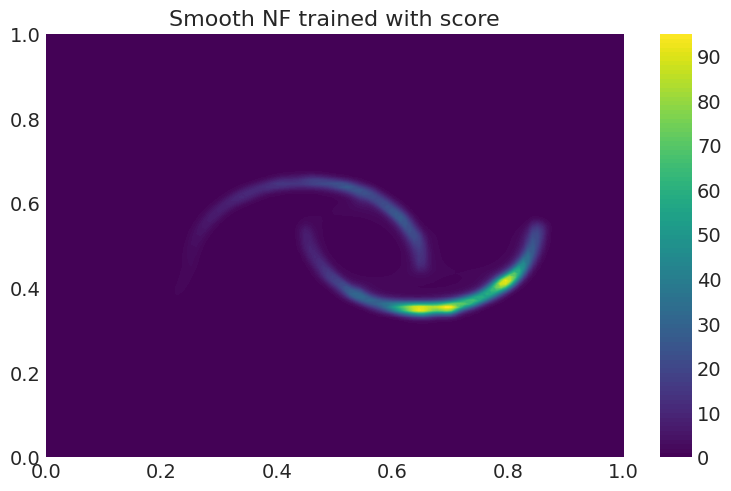

In [64]:
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

im0 = jax.vmap((lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im0), 100); colorbar()
plt.title('Smooth NF trained with score')
plt.savefig("smoothnf.png")
jnp.save('nfcool.npy', im0)

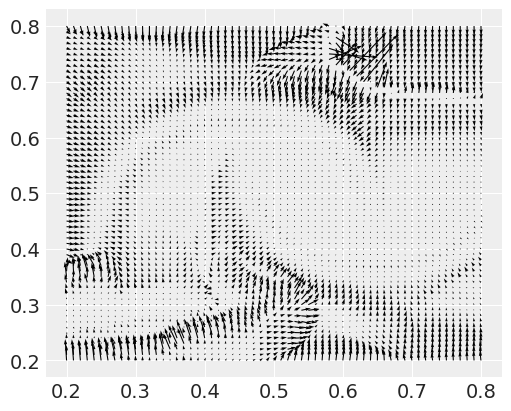

In [65]:
plt.figure(figsize=(5,4))
X = np.arange(0.2, 0.8, 0.01)
Y = np.arange(0.2, 0.8, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
pred_score = jax.vmap(jax.grad(lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(points).reshape([len(Y), len(X),2])
quiver(X, Y, pred_score[:,:,0] ,pred_score[:,:,1]);


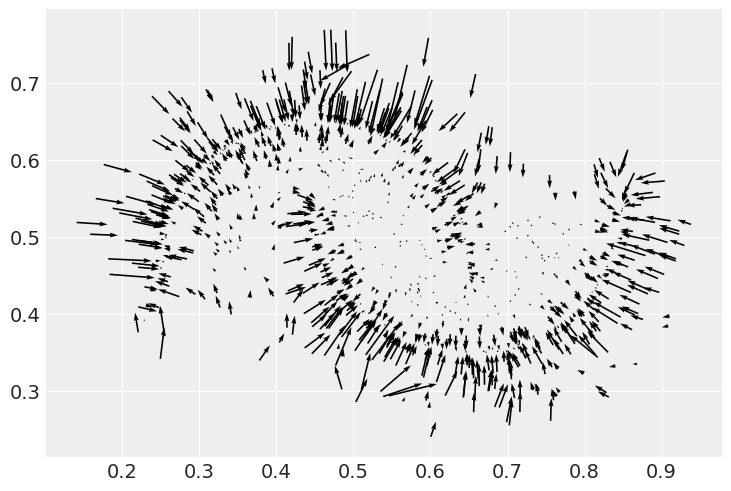

In [66]:
two_moons = get_two_moons(sigma = 0.05, normalized=True)
batch=two_moons.sample(1000, seed=next(master_seed))
pred_score = jax.vmap(jax.grad(lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(batch)
quiver(batch.T[0], batch.T[1], pred_score[:,0] ,pred_score[:,1]);

In [30]:
from sbids.metrics.c2st import c2st

In [43]:
two_moons = get_two_moons(sigma = 0.01, normalized=True)
reference_batch = two_moons.sample(10000, seed=jax.random.PRNGKey(0))

In [56]:
sample_affine_model = hk.transform(lambda : tfd.TransformedDistribution(NF_affine(2)(jnp.ones([10000,1])), 
                                           tfb.Invert(transformation_params)).sample(10000, seed=hk.next_rng_key()))

sample_smooth_model = hk.transform(lambda : tfd.TransformedDistribution(NF_smooth(2)(jnp.ones([10000,1])), 
                                           tfb.Invert(transformation_params)).sample(10000, seed=hk.next_rng_key()))

In [73]:
sample_affine = sample_affine_model.apply(params_affine, rng = next(rng_seq))
sample_smooth = sample_smooth_model.apply(params_smooth, rng = next(rng_seq))

In [74]:
metric_affine = c2st(reference_batch,sample_affine,5,5)
metric_smooth = c2st(reference_batch,sample_smooth,5,5)

In [75]:
print(metric_affine)
print(metric_smooth)

0.93
0.66125
